In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

z_int_steps = jnp.load(f"{sim_folder}/z_int_steps.npy")
s_int_steps = jnp.load(f"{sim_folder}/s_int_steps.npy")

#! Broken halos: either snapshot info missing or anomalous number densities
exclude_nums = jnp.array([
    20,
    21,
    24,
    25,
])
halo_nums = [x for x in range(1, 31) if x not in exclude_nums]


# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")[tuple(halo_nums),...]
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")[tuple(halo_nums),...]

# pix_dens_FD = jnp.delete(pix_dens_FD, exclude_nums, axis=0)
# tot_dens_FD = jnp.delete(tot_dens_FD, exclude_nums, axis=0)
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

#! some change/bug in the sim_execute script, now FD also only has 5 masses instead of 50.

(26, 5, 768)
(26, 50)


## Power Spectra

### Plotting function

In [ ]:
def power_spectra_FDxPF_decay(
    m_pick, pix_dens_FD, pix_dens_PF, y_lims, sim_dir, gamma, args):
    
    m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*args.eV
    m_range = jnp.load(f"{sim_dir}/neutrino_massrange_eV.npy")

    mPF_i = jnp.abs(m_specs - m_pick).argmin()
    # mFD_i = jnp.abs(m_range - m_pick).argmin()
    mFD_i = jnp.abs(m_specs - m_pick).argmin()

    halo_num = len(pix_dens_FD)

    power_spectra_FD_l = []
    power_spectra_PF_l = []
    for halo_i in range(halo_num):

        m_nu = m_specs[mFD_i]

        FD_skymap = pix_dens_FD[halo_i, mFD_i]
        PF_skymap = pix_dens_PF[halo_i, mPF_i]

        # Convert maps of neutrino densities to temperatures.
        cm3 = args.cm**3
        FD_Tmap = np.cbrt((FD_skymap*(1/cm3)*4*args.Pi**2) / (args.g_nu*3*zeta(3)))
        PF_Tmap = np.cbrt((PF_skymap*(1/cm3)*4*args.Pi**2) / (args.g_nu*3*zeta(3)))

        T_unit = args.muK
        FD_Tmap /= T_unit
        PF_Tmap /= T_unit

        # Compute power spectrum of number density all-sky map.
        cl_FD = hp.sphtfunc.anafast(FD_Tmap, lmax=None)
        cl_PF = hp.sphtfunc.anafast(PF_Tmap, lmax=None)

        ell = jnp.arange(len(cl_FD))

        # Unit to compare to similar figures in literature.
        # scaling = Primordial.Cl_scaling
        scaling = 1  # if Tmaps already in muK
        
        power_spectrum_PF = ell * (ell+1) * cl_PF * scaling / (2*args.Pi)
        power_spectrum_FD = ell * (ell+1) * cl_FD * scaling / (2*args.Pi)
        
        power_spectra_FD_l.append(power_spectrum_FD)
        power_spectra_PF_l.append(power_spectrum_PF)


    # Convert lists to arrays
    power_spectra_FD = jnp.array(power_spectra_FD_l)
    power_spectra_PF = jnp.array(power_spectra_PF_l)
    # power_spectra_FD = savgol_filter(jnp.array(power_spectra_FD_l), 4, 2)
    # power_spectra_PF = savgol_filter(jnp.array(power_spectra_PF_l), 4, 2)

    # Compute median and percentile ranges for Fermi-Dirac spectra
    power_median_FD = jnp.median(power_spectra_FD, axis=0)
    power_perc2p5_FD = jnp.percentile(power_spectra_FD, q=2.5, axis=0)
    power_perc97p5_FD = jnp.percentile(power_spectra_FD, q=97.5, axis=0)
    power_perc16_FD = jnp.percentile(power_spectra_FD, q=16, axis=0)
    power_perc84_FD = jnp.percentile(power_spectra_FD, q=84, axis=0)

    # Compute median and percentile ranges for Primordial Fluctuations spectra
    power_median_PF = jnp.median(power_spectra_PF, axis=0)
    power_perc2p5_PF = jnp.percentile(power_spectra_PF, q=2.5, axis=0)
    power_perc97p5_PF = jnp.percentile(power_spectra_PF, q=97.5, axis=0)
    power_perc16_PF = jnp.percentile(power_spectra_PF, q=16, axis=0)
    power_perc84_PF = jnp.percentile(power_spectra_PF, q=84, axis=0)


    fig = plt.figure(figsize =(6, 4))
    fig.tight_layout()
    ax1 = fig.add_subplot(111)

    FD_color = "mediumblue"
    ax1.semilogy(
        ell, power_median_FD, color=FD_color, 
        label=f"Parents")
    ax1.fill_between(
        ell, power_perc16_FD, power_perc84_FD, 
        color=FD_color, alpha=0.25, label=r"$68\%$ C.L.")
    # ax1.fill_between(
    #     ell, power_perc2p5_FD, power_perc97p5_FD, 
    #     color=FD_color, alpha=0.15, label=r"$95\%$ C.L.")

    PF_color = "red"
    ax1.semilogy(
        ell, power_median_PF, color=PF_color, 
        label=f"Daughters", ls="solid")
    ax1.fill_between(
        ell, power_perc16_PF, power_perc84_PF, 
        color=PF_color, alpha=0.3, label=r"$68\%$ C.L.")
    # ax1.fill_between(
    #     ell, power_perc2p5_PF, power_perc97p5_PF, 
    #     color=PF_color, alpha=0.2, label=r"$95\%$ C.L.")


    ax1.set_title(fr"$m_\nu = {m_pick}$ eV ; $\tau = {gamma}$")
    ax1.set_xlabel("$\ell$")
    # ax1.set_xlim(1,np.max(ell))
    ax1.set_xlim(1,21)
    ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell} \, / \, 2\pi \,\, [\mu K^2]$")

    if y_lims is None:
        ax1.set_ylim(1e4, 1e11)
    else:
        ax1.set_ylim(y_lims[0], y_lims[1])

    ax1.grid(visible=True, which="major", ls="dashed", alpha=0.5)
    ax1.legend(loc='upper right', prop={'size':14})

    plt.savefig(
        f"{fig_folder}/power_spectra_decay_lifetime_{gamma}.pdf", 
        bbox_inches="tight")
    plt.show(); plt.close()

### Parents and daughter plots

In [ ]:
data_sim_folder = f"sim_output/no_gravity_decay"

gammas = np.array(["0.1T", "0.5T", "1T", "1.5T", "2T"])
for Gamma_str in gammas:

    # Combine the two index arrays (containing the 0s and 1s), upto and above 
    # redshift of sim boundary
    decayed_neutrinos_z_above_sim = jnp.load(
        f'{data_sim_folder}/decayed_neutrinos_z_above_sim_{Gamma_str}.npy'
    ).reshape(-1, simdata.Npix, simdata.p_num)
    decayed_neutrinos_z = jnp.load(
        f'{data_sim_folder}/decayed_neutrinos_z_{Gamma_str}.npy'
    ).reshape(-1, simdata.Npix, simdata.p_num)

    # print(decayed_neutrinos_z_above_sim.shape, decayed_neutrinos_z.shape)

    decay_perc_data = jnp.load(f"{data_sim_folder}/decayed_neutrinos_perc.npy")
    # print(decay_perc_data)
    # print(decay_perc_data/100*Params.N0_cm3)

    # Neutrino percentages (parents vs. daughters) today via the 0s and 1s method
    perc_parents_per_pix = jnp.sum(decayed_neutrinos_z[-1], axis=-1)/simdata.p_num
    perc_daughters_per_pix = 1-perc_parents_per_pix

    # print("\n",perc_parents_per_pix.shape, perc_parents_per_pix[::100]*Params.N0_cm3)
    # print("\n",perc_daughters_per_pix.shape, perc_daughters_per_pix[::100]*Params.N0_cm3)


    N0_pix = Params.N0 / simdata.Npix
    skymap_norm = N0_pix / (Params.cm**-3)


    # Parent all-sky map
    parent_map = perc_parents_per_pix[None,None,:]*pix_dens_FD

    # Daughter all-sky map
    daughter_map = perc_daughters_per_pix[None,None,:]*pix_dens_FD

    for m_pick in nu_m_picks[2:3]:
        print(m_pick)
        power_spectra_FDxPF_decay(
            m_pick=m_pick, 
            pix_dens_FD=parent_map - skymap_norm, 
            pix_dens_PF=daughter_map - skymap_norm,
            y_lims=(1e5, 1e11),
            sim_dir=sim_folder,
            gamma=Gamma_str,
            args=Params)

## Anisotropy skymaps

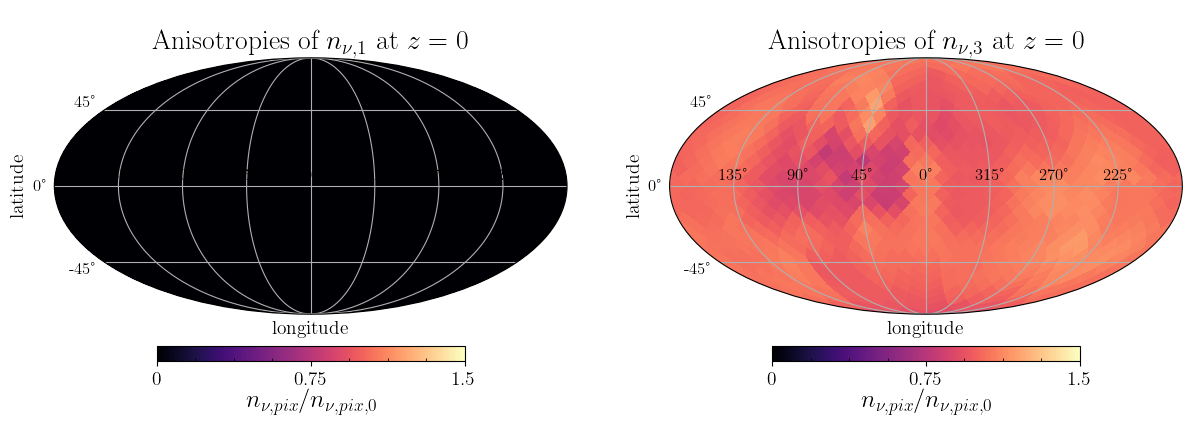

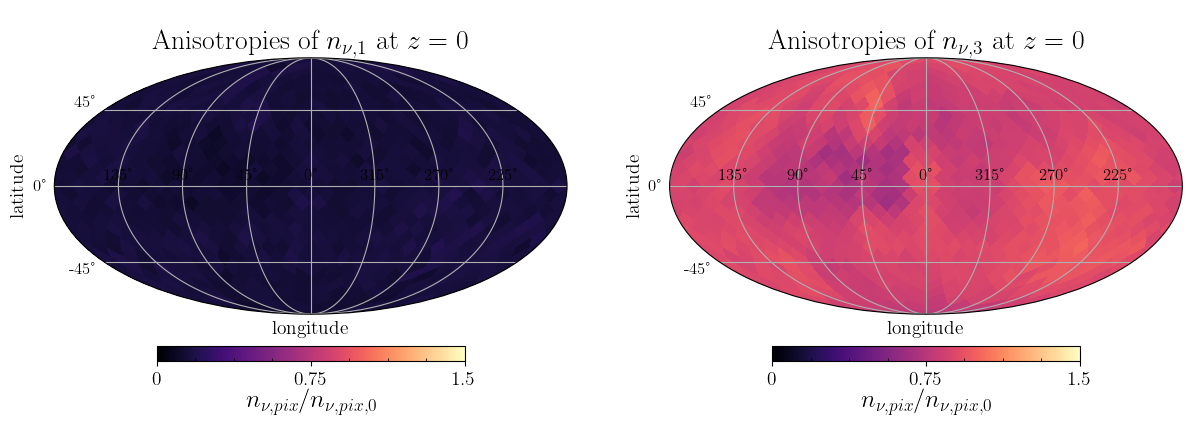

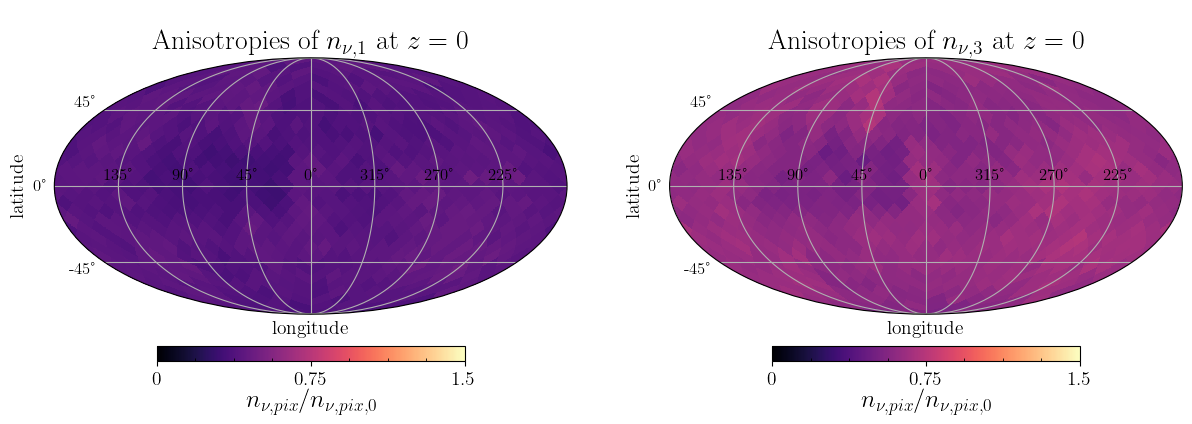

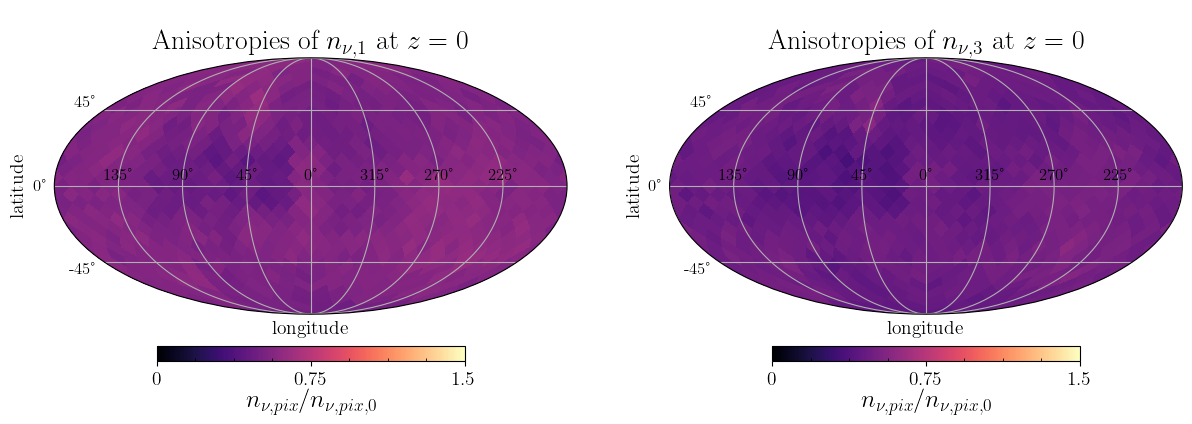

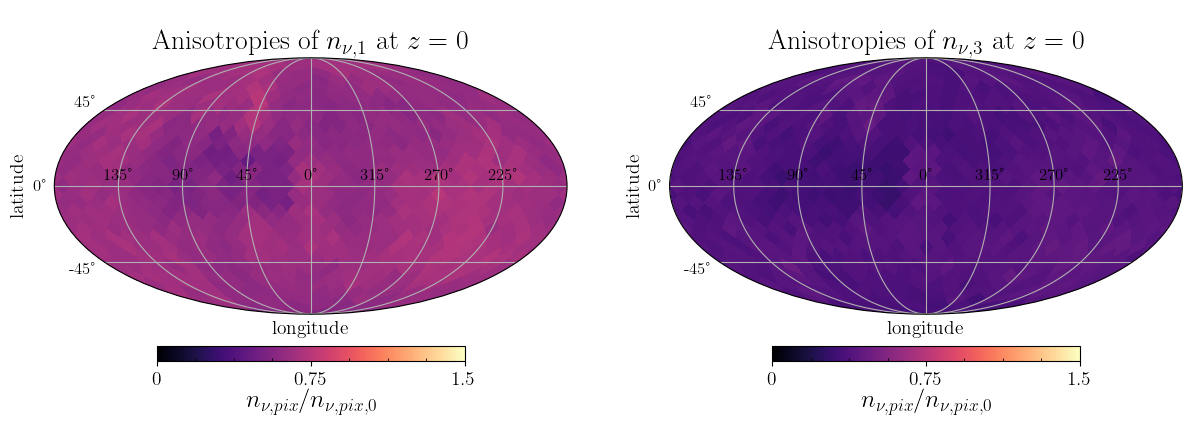

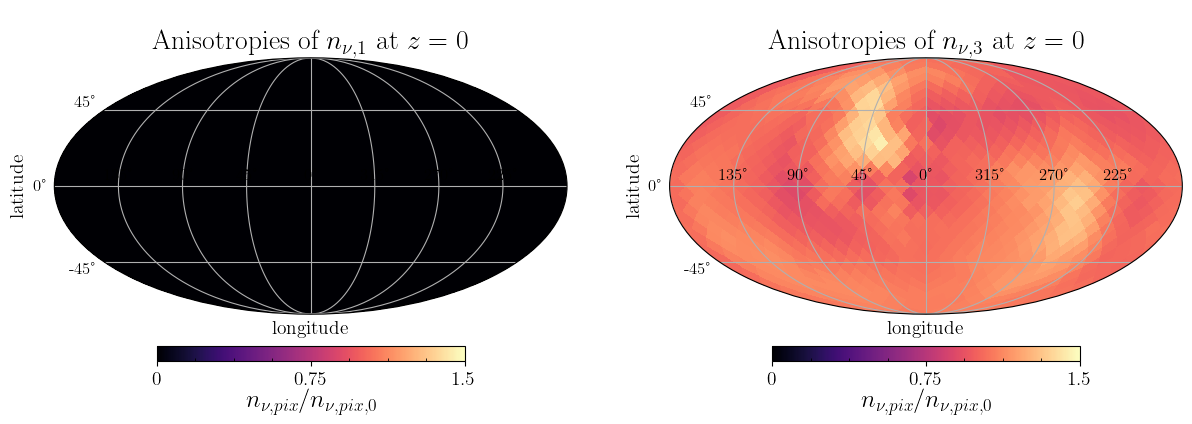

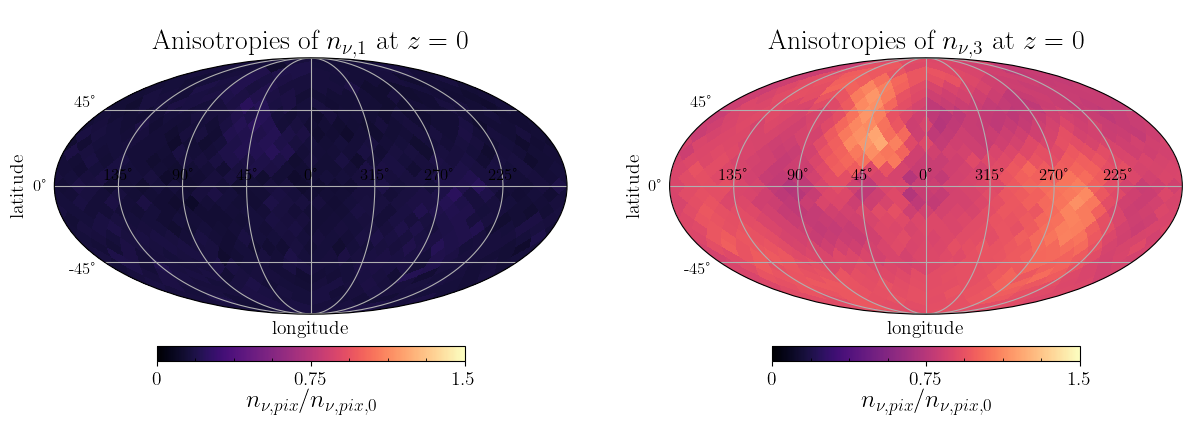

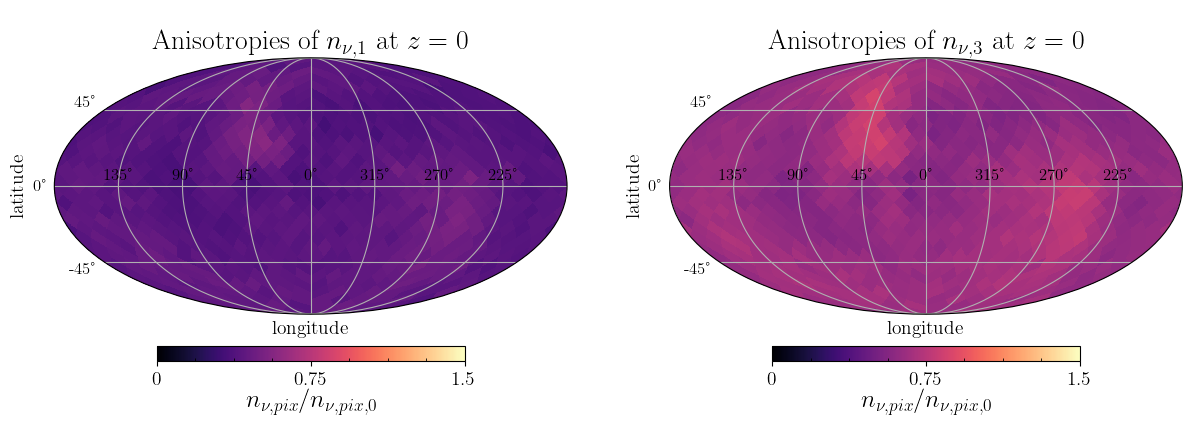

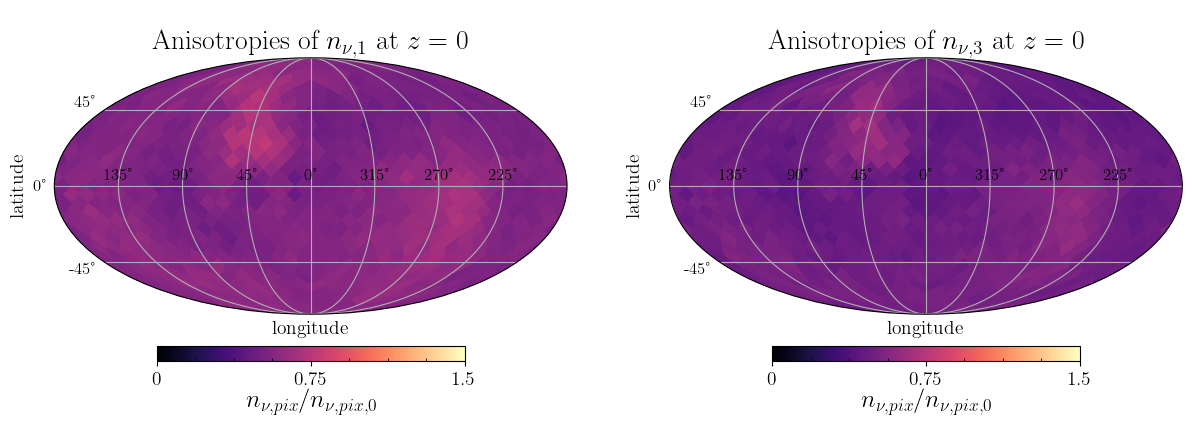

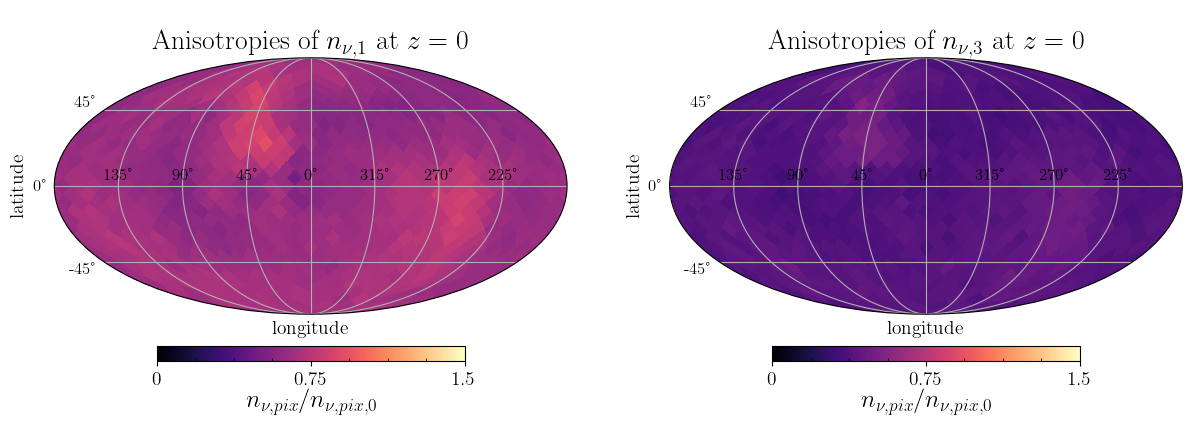

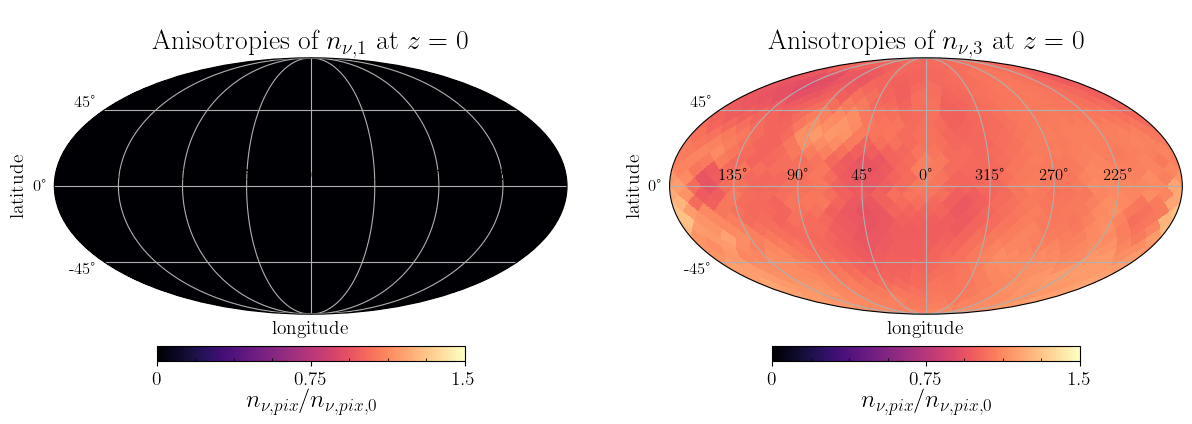

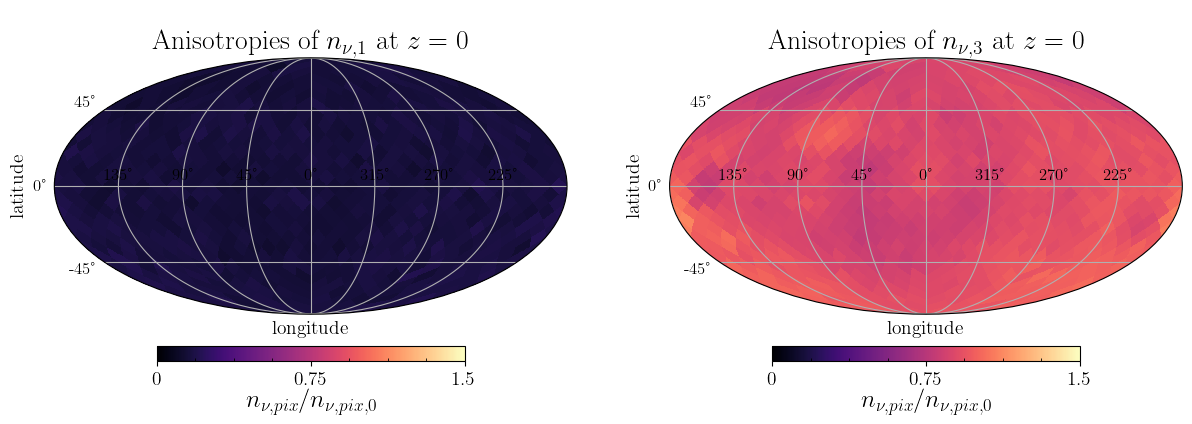

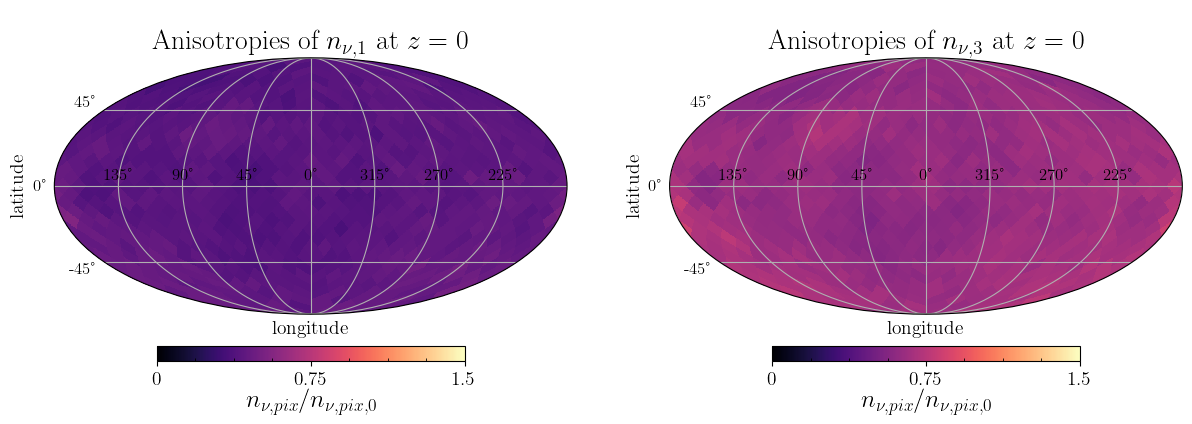

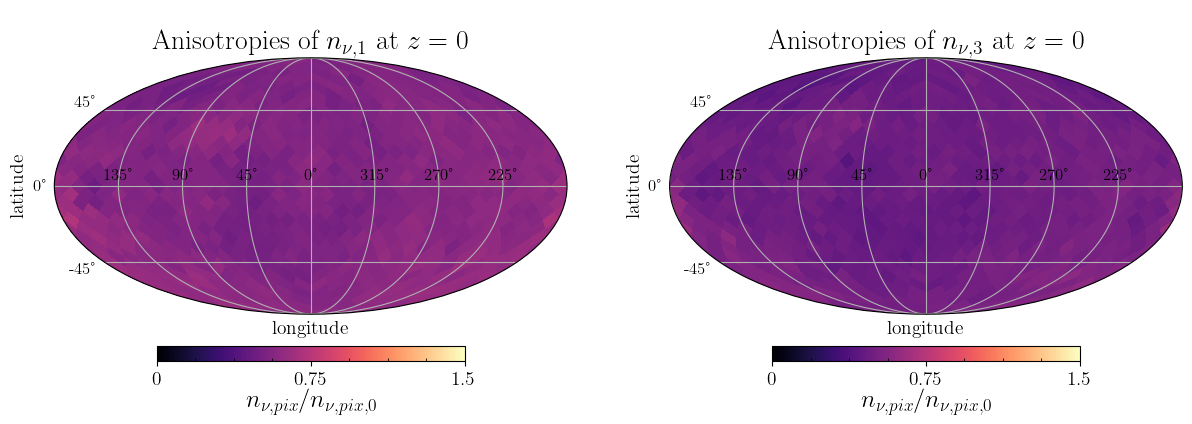

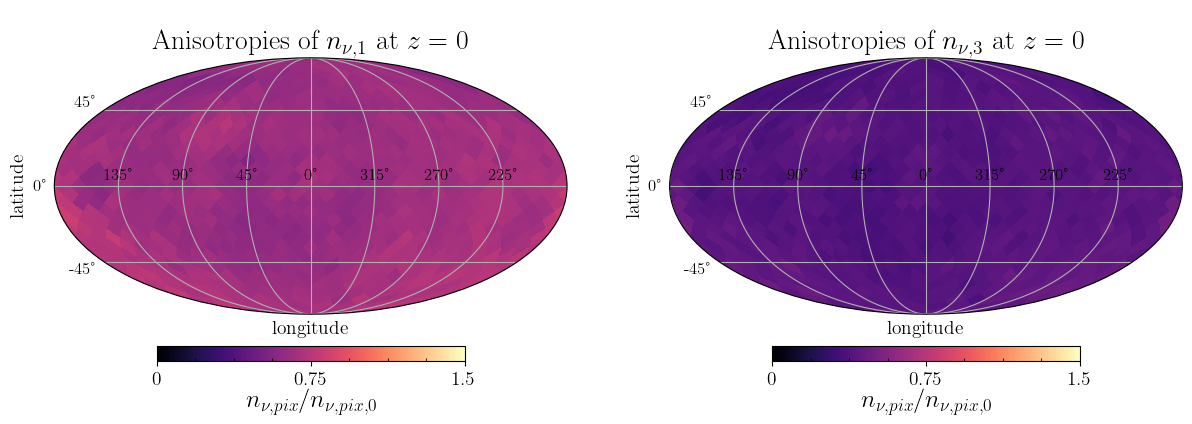

In [8]:
from matplotlib.colors import ListedColormap

data_sim_folder = f"sim_output/no_gravity_decay"

# tau_values = [f"{i/10:.1f}T" for i in range(1, 21)]
gamma_vals = np.array(["0.1T", "0.5T", "1T", "1.5T", "2T"])

for halo_i in (3,7,10):
# for halo_i in (3,):

    for gamma in gamma_vals:

        # Combine the two index arrays (containing the 0s and 1s), upto and above 
        # redshift of sim boundary
        decayed_neutrinos_z_above_sim = jnp.load(
            f'{data_sim_folder}/decayed_neutrinos_z_above_sim_{gamma}.npy'
        ).reshape(-1, simdata.Npix, simdata.p_num)
        decayed_neutrinos_z = jnp.load(
            f'{data_sim_folder}/decayed_neutrinos_z_{gamma}.npy'
        ).reshape(-1, simdata.Npix, simdata.p_num)

        # print(decayed_neutrinos_z_above_sim.shape, decayed_neutrinos_z.shape)

        decay_perc_data = jnp.load(f"{data_sim_folder}/decayed_neutrinos_perc.npy")
        # print(decay_perc_data)
        # print(decay_perc_data/100*Params.N0_cm3)

        
        # Neutrino percentages (parents vs. daughters) today via the 0s and 1s method
        perc_parents_per_pix = jnp.sum(decayed_neutrinos_z[-1], axis=-1)/simdata.p_num
        perc_daughters_per_pix = 1-perc_parents_per_pix


        # Parent all-sky map
        parent_map = perc_parents_per_pix[None,None,:]*pix_dens_FD

        # Daughter all-sky map
        daughter_map = perc_daughters_per_pix[None,None,:]*pix_dens_FD

        # ic(parent_map.shape)
        # ic(daughter_map.shape)

        # Choose a halo and mass to display
        m_pick = 0.1
        mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
        mFD_i = jnp.abs(nu_m_picks - m_pick).argmin()

        N0_pix = Params.N0 / simdata.Npix
        skymap_norm = N0_pix / (Params.cm**-3)


        ### ------------------------------------------- ###
        ### Plot parameters for parent neutrinos skymap ###
        ### ------------------------------------------- ###

        PF_skymap = parent_map[halo_i, mPF_i, :] / skymap_norm
        mid_PF = 0.75

        cmap = plt.get_cmap('magma')
        colors = cmap(np.linspace(0, 1, 256))
        mid_index = 128  # Middle index
        selected_colors = colors[:mid_index]
        custom_cmap = ListedColormap(selected_colors)

        # Make center value to be 1 or 0 (no overdensity).
        # mid_PF = skymap_norm
        divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

        # Plot style healpy dictionary for right skymap
        ticks_l_PF = [0, mid_PF, 1.5]
        dict_PF = dict(
            title=fr"Anisotropies of $n_{{\nu,1}}$ at $z=0$",
            unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
            cmap="magma",
            # cmap=custom_cmap,
            override_plot_properties={"cbar_pad": 0.08},
            fontsize={
                "title": 20, 
                "xlabel": 14,
                "ylabel": 14,
                "cbar_label": 18,
                "cbar_tick_label": 14,
            },
            cbar_ticks=ticks_l_PF,
            norm=divnorm_PF,
            sub=121)

        ### ----------------------------------- ###
        ### Plot parameters for daughter skymap ###
        ### ----------------------------------- ###

        FD_skymap = daughter_map[halo_i, mFD_i, :] / skymap_norm
        mid_FD = 0.75

        # Make center value to be 1 or 0 (no overdensity).
        divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

        # Plot style healpy dictionary for left skymap
        ticks_l_FD = [0, mid_FD, 1.5] 
        dict_FD = dict(
            title=fr"Anisotropies of $n_{{\nu,3}}$ at $z=0$",
            unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
            cmap="magma",
            # cmap=custom_cmap,
            override_plot_properties={"cbar_pad": 0.08},
            fontsize={
                "title": 20, 
                "xlabel": 14,
                "ylabel": 14,
                "cbar_label": 18,
                "cbar_tick_label": 14,
            },
            cbar_ticks=ticks_l_FD,
            norm=divnorm_FD,
            sub=122)


        ### ------------ ###
        ### Plot skymaps ###
        ### ------------ ###

        fig_paths = [
            f"{fig_folder}/anisotropy_skymaps_decay_halo{halo_i}_{gamma}.pdf",
            f"{fig_folder}/anisotropy_skymaps_decay_halo{halo_i}_{gamma}.png"
        ]

        SimPlot.healpix_side_by_side(
            map_left=PF_skymap,
            map_right=FD_skymap,
            dict_left=dict_PF,
            dict_right=dict_FD,
            fig_paths=fig_paths,
            args=Params)